Solar Panels 

In [18]:
# ===========================
# import necessary Libraries
# ===========================

import sys, os, glob, gc
import joblib
import pandas as pd
import types
import numpy as np
from helper import fill_missing_values, drop_missing_values
from helper import plot_outliers



In [19]:
# ====== patch for compatibility with old pandas version ======
def patch_pandas_index_compat():
    import pandas as _pd
    import types as _types
    numeric = _types.ModuleType("pandas.core.indexes.numeric")
    class Int64Index(_pd.Index):
        def __new__(cls, data=None, dtype=None, copy=False, name=None):
            return _pd.Index(data, dtype="int64", copy=copy, name=name)
    numeric.Int64Index = Int64Index
    numeric.RangeIndex = _pd.RangeIndex
    sys.modules['pandas.core.indexes.numeric'] = numeric

    dat = _types.ModuleType("pandas.core.indexes.datetimes")
    dat.DatetimeIndex = _pd.DatetimeIndex
    sys.modules['pandas.core.indexes.datetimes'] = dat

    tdel = _types.ModuleType("pandas.core.indexes.timedeltas")
    tdel.TimedeltaIndex = _pd.TimedeltaIndex
    sys.modules['pandas.core.indexes.timedeltas'] = tdel

patch_pandas_index_compat()


In [ ]:
# ===============================================================
# Create a new HDF5 file to store merged data from multiple .pkl files

import os
import pandas as pd
import glob  # Used to find all matching .pkl files in the directory

# Define the path to the HDF5 file
store_path = "/Users/shthaz/desktop/Solar_Panels/Data/all_data.h5"

# Close any existing HDFStore object if already open in the current session
try:
    store.close()
except NameError:
    pass  # 'store' was not defined yet, so nothing to close

# Remove the old HDF5 file if it already exists
if os.path.exists(store_path):
    os.remove(store_path)

# Create a new empty HDF5 store (with high compression)
with pd.HDFStore(store_path, mode='w', complevel=9, complib='blosc') as store:
    print("✅ HDF5 store created successfully.")
    # Data can be added to this store later

# Define the directory containing all .pkl data files
DATA_DIR = os.path.expanduser("~/desktop/Solar_Panels/Data")

# Reconstruct the HDF5 file path (for consistency)
store_path = os.path.join(DATA_DIR, "all_data.h5")

# Remove the file again if it exists (to ensure a clean start)
if os.path.exists(store_path):
    os.remove(store_path)

# Open a new HDFStore for writing data
store = pd.HDFStore(store_path, mode='w', complevel=9, complib='blosc')

# Find all .pkl files in the data directory that start with "df"
files = sorted(glob.glob(os.path.join(DATA_DIR, "df*.pkl")))

# Display how many files were found and their names
print(f"Found {len(files)} files:", files)

# If no .pkl files were found, close the store and stop execution
if len(files) == 0:
    print("No files found. Exiting.")
    store.close()
    raise SystemExit



✅ HDF5 store created successfully.
Found 5 files: ['/Users/shthaz/desktop/Solar_Panels/Data/df1.pkl', '/Users/shthaz/desktop/Solar_Panels/Data/df2.pkl', '/Users/shthaz/desktop/Solar_Panels/Data/df3.pkl', '/Users/shthaz/desktop/Solar_Panels/Data/df4.pkl', '/Users/shthaz/desktop/Solar_Panels/Data/df5.pkl']


In [ ]:
# =========================
# Function to clean and standardize column names
# =========================
def clean_columns(cols):
    # Remove extra spaces, replace special characters with underscores, and remove parentheses or slashes
    return [
        c.strip()
         .replace(' ', '_')
         .replace('(', '')
         .replace(')', '')
         .replace('/', '_')
         .replace('\n', '')
        for c in cols
    ]

# =========================
# Load the first .pkl file to define column template and data types
# =========================
df0 = joblib.load(files[0])  # Load the first dataset
df0.columns = clean_columns(df0.columns)  # Clean column names for consistency

# Identify datetime columns (if any)
datetime_cols0 = df0.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
if len(datetime_cols0) > 0:
    print(f"⚠️ Found datetime columns in first file: {list(datetime_cols0)} (keeping them for time-based analysis)")
    # Datetime columns are kept for later time-based processing

# Store column names and data types as a template for other files
all_columns = df0.columns.tolist()
column_dtypes = df0.dtypes.to_dict()

# Free up memory by deleting the temporary dataframe
del df0
gc.collect()

# Confirm the template columns were successfully recorded
print(f"\n✅ Template Columns ({len(all_columns)} total) recorded.")


⚠️ Found datetime columns in first file: ['Time'] (keeping them for time-based analysis)

✅ Template Columns (23 total) recorded.


In [ ]:
# =========================
# Append each .pkl file to the HDF5 store (align columns safely)
# =========================
for f in files:
    print(f"\nLoading {os.path.basename(f)} ...")
    df = joblib.load(f)  # Load the current .pkl file
    print(f"  Original shape: {df.shape}")

    # Clean column names for consistency
    df.columns = clean_columns(df.columns)

    # Identify datetime columns (if any)
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
    if len(datetime_cols) > 0:
        print(f"  Keeping datetime columns for later processing: {list(datetime_cols)}")
        # Datetime columns are kept for further time-based analysis

    # ---------------------------
    # Align columns with the template (fill missing columns with NA)
    # ---------------------------
    src_cols = df.columns.tolist()          # Columns in the current file
    n_template = len(all_columns)           # Number of columns in the template
    n_src = len(src_cols)                   # Number of columns in this file

    # Case 1: Source has equal or more columns than template
    if n_src >= n_template:
        df = df.iloc[:, :n_template].copy()  # Keep only the first N columns
        df.columns = all_columns             # Rename columns to match the template
        if n_src > n_template:
            print(f"  Note: source has {n_src} cols, taking first {n_template}.")

    # Case 2: Source has fewer columns than template
    else:
        df = df.copy()
        df.columns = all_columns[:n_src]     # Assign available names to existing columns
        for col in all_columns[n_src:]:
            df[col] = pd.NA                  # Add missing columns filled with NA
        df = df[all_columns]                 # Reorder columns to match the template
        print(f"  Note: source has {n_src} cols, filled remaining {n_template - n_src} with NA.")

    # ---------------------------
    # Append the aligned DataFrame to the HDF5 store
    # ---------------------------
    store.append('df', df, format='table', data_columns=True)
    print(f"  Added to HDF5. Current total rows: {store.get_storer('df').nrows}")

    # Free up memory after each iteration
    del df
    gc.collect()

# Close the HDF5 store after processing all files
store.close()
print("\n✅ All files combined successfully into:", store_path)



Loading df1.pkl ...
  Original shape: (528097, 23)

Loading df2.pkl ...
  Original shape: (528097, 23)

Loading df3.pkl ...
  Original shape: (528097, 23)

Loading df4.pkl ...
  Original shape: (528097, 23)

Loading df5.pkl ...
  Original shape: (528097, 23)
  Keeping datetime columns for later processing: ['Time']


/Users/shthaz/Desktop/Solar_Panels/.venv/lib/python3.11/site-packages/tables/path.py:146: NaturalNameWarning: object name is not a valid Python identifier: 'Ambient_Temp._degree_centigrade'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/shthaz/Desktop/Solar_Panels/.venv/lib/python3.11/site-packages/tables/path.py:146: NaturalNameWarning: object name is not a valid Python identifier: 'Relative_Humidity_%'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/shthaz/Desktop/Solar_Panels/.venv/lib/python3.11/site-packages/tables/path.py:146: NaturalNameWarning: object name is not a valid Python identifier: 'Soiling_Loss_IndexIsc%'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0

  Added to HDF5. Current total rows: 528097

✅ All files combined successfully into: /Users/shthaz/desktop/Solar_Panels/Data/all_data.h5


In [ ]:
from helper import drop_missing_values, fill_missing_values

# ============================================
# 🧹 Data Cleaning and Preprocessing Before Feature Selection
# ============================================

import os
import numpy as np
import pandas as pd
from helper import drop_missing_values, fill_missing_values  # ✅ Import helper functions

print("\n🔧 Cleaning missing values and preparing dataset...")

# -----------------------------
# 1️⃣ Load data from the HDF5 file
# -----------------------------
with pd.HDFStore(store_path, mode='r') as store:
    df_all = store['df']

print(f"✅ Loaded dataset with shape: {df_all.shape}")

# -----------------------------
# 2️⃣ Drop rows with missing target values
# -----------------------------
target_col = df_all.columns[-1]  # Assume the last column is the target column
before_drop = len(df_all)

# ✅ Remove rows where the target column has missing values (using helper function)
df_all = drop_missing_values(df_all, columns=[target_col])

print(f"🗑️ Removed {before_drop - len(df_all)} rows with missing target values. New shape: {df_all.shape}")

# -----------------------------
# 3️⃣ Create a 'Day_Night' column based on the time column
# -----------------------------
if 'Time' in df_all.columns:
    # Convert the 'Time' column to datetime format
    df_all['Time'] = pd.to_datetime(df_all['Time'], errors='coerce')

    # Extract hour and minute from the timestamp
    df_all['hour'] = df_all['Time'].dt.hour
    df_all['minute'] = df_all['Time'].dt.minute

    # Classify time period as 'day' (6 AM–6 PM) or 'night' (otherwise)
    df_all['Day_Night'] = np.where((df_all['hour'] >= 6) & (df_all['hour'] < 18), 'day', 'night')

    # Replace target values at night with 0 to remove negative or irrelevant readings
    df_all.loc[df_all['Day_Night'] == 'night', target_col] = 0

    print("🌙 Nighttime target values replaced with 0.")

# -----------------------------
# 4️⃣ Handle duplicate timestamps
# -----------------------------
if 'Time' in df_all.columns:
    # Sort dataset by time in ascending order
    df_all = df_all.sort_values('Time')

    # Identify duplicate timestamps
    duplicates = df_all[df_all.duplicated(subset='Time', keep=False)]

    if not duplicates.empty:
        print(f"⚠️ Found {len(duplicates)//2} duplicate time entries. Averaging values...")

        # Merge duplicate rows by averaging all numeric columns
        df_all = df_all.groupby('Time', as_index=False).mean(numeric_only=True)
    else:
        print("✅ No duplicate time entries found.")

# -----------------------------
# 5️⃣ Fill missing values using helper function (Linear Interpolation)
# -----------------------------
# Use linear interpolation instead of statistical mean to maintain time-series continuity
df_all = fill_missing_values(df_all, use_interpolation=True)
print("🧮 Missing values filled using helper function (linear interpolation).")

# -----------------------------
# 6️⃣ (Optional) Check time continuity (minute-by-minute)
# -----------------------------
if 'Time' in df_all.columns:
    expected_range = pd.date_range(df_all['Time'].min(), df_all['Time'].max(), freq='1min')
    if len(expected_range) == len(df_all):
        print("✅ Time data is continuous and minute-by-minute (no gaps).")
    else:
        print(f"⚠️ Warning: Expected {len(expected_range)} minutes but found {len(df_all)} rows. Possible time gaps detected.")

# -----------------------------
# 7️⃣ Drop time-related columns (not needed for model training)
# -----------------------------
if 'Time' in df_all.columns:
    # Drop temporary columns used for time analysis
    df_all = df_all.drop(columns=['Time', 'hour', 'minute', 'Day_Night'], errors='ignore')
    print("🕒 Dropped time-related columns.")

# -----------------------------
# 8️⃣ Save the cleaned and imputed dataset (without splitting X and y)
# -----------------------------
temp_clean_path = os.path.join(DATA_DIR, "all_data_clean_imputed.h5")

# Remove any existing file before saving the new one
if os.path.exists(temp_clean_path):
    os.remove(temp_clean_path)

# Save the cleaned dataset in HDF5 format
df_all.to_hdf(temp_clean_path, key='df', mode='w', complevel=9, complib='blosc', format='table')

print(f"✅ Saved cleaned & imputed data to: {temp_clean_path}")



🔧 Cleaning missing values and preparing dataset...
✅ Loaded dataset with shape: (528097, 23)
🗑️ Removed 1426 rows with missing target values. New shape: (526671, 23)
🌙 Nighttime target values replaced with 0.
⚠️ Found 2933 duplicate time entries. Averaging values...
🧮 Missing values filled using linear interpolation between previous and next values.
⚠️ Warning: Expected 527039 minutes but found 523738 rows. There may be gaps in the timeline.
🕒 Dropped time-related columns.
✅ Saved cleaned & imputed data to: /Users/shthaz/desktop/Solar_Panels/Data/all_data_clean_imputed.h5


In [ ]:
# ============================================
# 🔀 Split Cleaned Data into Train/Test Sets
# ============================================

test_size = 0.2             # 20% of data will be used for testing
random_state = 42           # Fixed seed for reproducibility
rng = np.random.RandomState(random_state)
chunksize = 200000          # Process data in chunks to save memory

train_path = os.path.join(DATA_DIR, "all_data_train_raw.h5")
test_path  = os.path.join(DATA_DIR, "all_data_test_raw.h5")

# Remove old split files if they exist
for p in (train_path, test_path):
    if os.path.exists(p):
        os.remove(p)

train_rows = 0
test_rows = 0

print("\n🔀 Splitting cleaned data into train/test...")

# Read the cleaned dataset in chunks and split each chunk randomly
for i, chunk in enumerate(pd.read_hdf(temp_clean_path, 'df', chunksize=chunksize)):
    # Create a boolean mask for test samples (True = goes to test set)
    mask = rng.rand(len(chunk)) < test_size

    # Split the chunk into train and test subsets
    train_chunk = chunk[~mask]
    test_chunk  = chunk[mask]

    # Append train and test chunks to their respective HDF5 files
    if len(train_chunk) > 0:
        train_chunk.to_hdf(train_path, key='df', mode='a', format='table', complevel=9, complib='blosc')
    if len(test_chunk) > 0:
        test_chunk.to_hdf(test_path, key='df', mode='a', format='table', complevel=9, complib='blosc')

    # Update row counters
    train_rows += len(train_chunk)
    test_rows  += len(test_chunk)

    print(f"Chunk {i+1}: total {len(chunk)} → train {len(train_chunk)}, test {len(test_chunk)}")

print(f"\n✅ Done splitting. Train rows: {train_rows}, Test rows: {test_rows}")



🔀 Splitting cleaned data into train/test...
Chunk 1: total 200000 → train 160051, test 39949
Chunk 2: total 200000 → train 160139, test 39861
Chunk 3: total 123738 → train 99053, test 24685

✅ Done splitting. Train rows: 419243, Test rows: 104495


In [ ]:
# ============================================================
# 🧼 Safe Imputation Check (ensure no data leakage & no NaNs remain)
# ============================================================
from sklearn.impute import SimpleImputer

print("\n⚙️ Checking for missing values (post-cleaning)...")

# Load the train and test datasets
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')

# Separate features (X) and target (y)
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test  = test_df.iloc[:, :-1]
y_test  = test_df.iloc[:, -1]

# Count missing values before imputation
missing_train = X_train.isna().sum().sum()
missing_test  = X_test.isna().sum().sum()

if missing_train == 0 and missing_test == 0:
    print("✅ No missing values detected in either train or test sets.")
else:
    print(f"⚠️ Missing values found → train: {missing_train}, test: {missing_test}")
    print("➡️ Applying safe imputation (fit on train only)...")

    # Initialize imputer with mean strategy
    imputer = SimpleImputer(strategy='mean')
    
    # Apply only to numeric columns
    numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

    # Fit imputer on training data (to avoid data leakage)
    imputer.fit(X_train[numeric_cols])
    
    # Transform both train and test using the same imputer
    X_train[numeric_cols] = imputer.transform(X_train[numeric_cols])
    X_test[numeric_cols]  = imputer.transform(X_test[numeric_cols])
    
    print("✅ Applied mean imputation safely (fit on train only).")

# ------------------------------------------------------------
# Save the final clean train/test datasets
# ------------------------------------------------------------
train_clean_path = os.path.join(DATA_DIR, "all_data_train_clean.h5")
test_clean_path  = os.path.join(DATA_DIR, "all_data_test_clean.h5")

# Remove old files if they exist
for p in (train_clean_path, test_clean_path):
    if os.path.exists(p):
        os.remove(p)

# Combine features and target, then save as compressed HDF5
pd.concat([X_train, y_train], axis=1).to_hdf(
    train_clean_path, key='df', mode='w', complevel=9, complib='blosc', format='table'
)
pd.concat([X_test, y_test], axis=1).to_hdf(
    test_clean_path, key='df', mode='w', complevel=9, complib='blosc', format='table'
)

print(f"✅ Saved clean train/test datasets:\nTrain: {train_clean_path}\nTest : {test_clean_path}")




⚙️ Checking for missing values (post-cleaning)...
✅ No missing values detected in either train or test sets.
✅ Saved clean train/test datasets:
Train: /Users/shthaz/desktop/Solar_Panels/Data/all_data_train_clean.h5
Test : /Users/shthaz/desktop/Solar_Panels/Data/all_data_test_clean.h5


In [ ]:
# ============================================================
# 📊 Detect and Visualize Outliers in the Training Dataset
# ============================================================

from helper import plot_outliers  # Custom function for outlier detection and visualization
import pandas as pd
import os

# Define the data directory and training dataset path
DATA_DIR = os.path.expanduser("~/desktop/Solar_Panels/Data")
train_clean_path = os.path.join(DATA_DIR, "all_data_train_clean.h5")

# Load the cleaned training dataset
df_train = pd.read_hdf(train_clean_path, 'df')

# Generate an outlier detection report using the helper function
outlier_report = plot_outliers(df_train)



📦 Checking outliers for 22 columns...

📋 Outlier Summary Report:
                                             Feature  Outliers Percentage
                                       Wind_Speedm_s      1409      1.42%
                           Soiling_Loss_Index_Geff_%      1140      1.15%
                              Soiling_Loss_IndexIsc%      1140      1.15%
                     Ambient_Temp._degree_centigrade       382      0.39%
                               Temperature_TestDeg_C       301      0.30%
                     Temperature_Reference_CellDeg_C       278      0.28%
                                       Daily_rain_mm        41      0.04%
 Total_Solar_Irradiance_on_Horizontal_Plane_GHI_W_m2        19      0.02%
       Module_Surface_Temperature1_degree_centigrade         3      0.00%
       Module_Surface_Temperature2_degree_centigrade         3      0.00%
                                       Geff_TestW_M2         2      0.00%
                                         Isc_T

In [ ]:
import pandas as pd
import numpy as np

# -----------------------------
# Function: Check numeric coercion safely without modifying the original DataFrame
# -----------------------------
def coerce_check_and_examples(df, name, show_examples=10):
    report = []
    examples = {}

    for col in df.columns:
        # Do not modify the original DataFrame; use a temporary conversion
        ser = df[col]

        # Count non-null values before conversion
        nonnull_before = ser.notna().sum()

        # Attempt to convert values to numeric (invalid values become NaN)
        coerced = pd.to_numeric(ser, errors='coerce')

        # Count non-null values after conversion
        nonnull_after = coerced.notna().sum()

        # Calculate how many values were coerced to NaN
        coerced_to_na = nonnull_before - nonnull_after
        percent_coerced = (coerced_to_na / nonnull_before * 100) if nonnull_before > 0 else 0.0

        # Capture examples of problematic (non-numeric) values
        bad_mask = ser.notna() & coerced.isna()
        bad_values = ser.loc[bad_mask].astype(str).unique().tolist()
        examples[col] = bad_values[:show_examples]  # store up to N examples

        # Store column-level summary
        report.append({
            'column': col,
            'coerced_to_NA': int(coerced_to_na),
            'nonnull_before': int(nonnull_before),
            'nonnull_after': int(nonnull_after),
            'percent_coerced': float(percent_coerced)
        })

    # Compile results into a summary DataFrame
    rep_df = pd.DataFrame(report).sort_values('percent_coerced', ascending=False).reset_index(drop=True)

    print(f"\n📋 Coercion check report for {name} (top 40 columns by percent_coerced):")
    with pd.option_context('display.max_rows', 40, 'display.max_columns', None, 'display.width', 120):
        print(rep_df.head(40).to_string(index=False))
    
    return rep_df, examples


# -----------------------------
# Run numeric coercion check on both train and test datasets
# (does NOT modify X_train or X_test)
# -----------------------------
rep_train, examples_train = coerce_check_and_examples(X_train, 'X_train', show_examples=10)
rep_test,  examples_test  = coerce_check_and_examples(X_test,  'X_test',  show_examples=10)

# -----------------------------
# Print examples of columns with non-numeric values (if found)
# -----------------------------
print("\n🔎 Examples of non-numeric values that would be coerced to NaN (train):")
for col, vals in examples_train.items():
    if len(vals) > 0:
        print(f" - {col}: {len(vals)} example(s): {vals}")

print("\n🔎 Examples of non-numeric values that would be coerced to NaN (test):")
for col, vals in examples_test.items():
    if len(vals) > 0:
        print(f" - {col}: {len(vals)} example(s): {vals}")

# -----------------------------
# Identify columns that are 100% numeric-safe (no coercion losses)
# -----------------------------
safe_train_cols = rep_train.loc[rep_train['percent_coerced'] == 0, 'column'].tolist()
print(f"\n✅ Columns that are SAFE (no coercion losses) in train: {len(safe_train_cols)} columns")
print(safe_train_cols)

# -----------------------------
# (Optional) Use only numeric-safe columns for feature selection (e.g., IG or PCC)
# -----------------------------
X_train_num = X_train[safe_train_cols].copy()
X_test_num  = X_test[[c for c in safe_train_cols if c in X_test.columns]].copy()

print(f"\n✅ Using {len(X_train_num.columns)} numeric-safe columns for IG/PCC calculations on train.")



📋 Coercion check report for X_train (showing top 40 by percent_coerced):
                                              column  coerced_to_NA  nonnull_before  nonnull_after  percent_coerced
  Total_Solar_Irradiance_on_Inclined_Plane_POA1_W_m2              0           99053          99053              0.0
                                       Daily_rain_mm              0           99053          99053              0.0
                                       Geff_TestW_M2              0           99053          99053              0.0
                     Temperature_Reference_CellDeg_C              0           99053          99053              0.0
                               Temperature_TestDeg_C              0           99053          99053              0.0
                                          Isc_RefAmp              0           99053          99053              0.0
                                         Isc_TestAmp              0           99053          99053              0.

In [ ]:
# ======================================================
# 🧹 Remove Duplicate Measurement Columns (W/m² vs Wh/m²)
#     + Drop Manually Specified Unwanted Irradiance Columns
# ======================================================

def remove_duplicate_measurement_columns(df):
    # 1️⃣ Identify all columns that include (W/m²) or (Wh/m²)
    cols = df.columns
    w_cols = [c for c in cols if "(W/m2)" in c or "_W_m2" in c]
    wh_cols = [c for c in cols if "(Wh/m2)" in c or "_Wh_m2" in c]

    to_drop = []
    # 2️⃣ Find matching pairs (e.g., same sensor measured in both W/m² and Wh/m²)
    for c_wh in wh_cols:
        base_name = c_wh.replace("(Wh/m2)", "(W/m2)").replace("_Wh_m2", "_W_m2")
        matches = [c for c in w_cols if base_name.split("(W/m2)")[0].strip() in c]
        if matches:
            to_drop.append(c_wh)

    # 3️⃣ Define additional manually specified columns to drop
    manual_drop = [
        # Duplicate irradiance columns with Wh/m² unit
        "Total_Solar_Irradiance_on_Inclined_Plane_POA1_Wh_m2",
        "Total_Solar_Irradiance_on_Inclined_Plane_POA2_Wh_m2",
        "Total_Solar_Irradiance_on_Horizontal_Plane_GHI_Wh_m2",

        # Manually requested removal (user-specified)
        "Total_Solar_Irradiance_on_Inclined_Plane_POA2_W_m2",
    ]

    # 4️⃣ Combine automatic and manual drop lists (remove duplicates)
    final_drop = list(set(to_drop + manual_drop))

    # 5️⃣ Drop existing columns safely (ignore if not found)
    existing_to_drop = [c for c in final_drop if c in df.columns]
    before_cols = len(df.columns)
    df = df.drop(columns=existing_to_drop, errors='ignore')
    after_cols = len(df.columns)

    # 6️⃣ Print a summary report of dropped columns
    print(f"🗑️ Dropped {len(existing_to_drop)} columns.")
    if existing_to_drop:
        print("   ➤ Columns removed:")
        for c in existing_to_drop:
            print(f"     - {c}")
    print(f"📊 Columns before: {before_cols} → after: {after_cols}\n")

    return df


# ======================================================
# 🧾 Apply the function on both train and test datasets
# ======================================================

print("\n🚀 Removing duplicate and unwanted irradiance columns...")

train_df = remove_duplicate_measurement_columns(train_df)
test_df  = remove_duplicate_measurement_columns(test_df)

print("✅ Duplicate irradiance columns removed successfully from both train and test sets.")

# 💾 Save the cleaned datasets (overwrite the previous versions)
train_df.to_hdf(train_clean_path, key='df', mode='w')
test_df.to_hdf(test_clean_path, key='df', mode='w')

print("✅ Saved cleaned train/test files — unwanted columns have been permanently removed.")



🚀 Removing duplicate and unwanted irradiance columns...
🗑️ Dropped 4 columns.
   ➤ Columns removed:
     - Total_Solar_Irradiance_on_Horizontal_Plane_GHI_Wh_m2
     - Total_Solar_Irradiance_on_Inclined_Plane_POA1_Wh_m2
     - Total_Solar_Irradiance_on_Inclined_Plane_POA2_Wh_m2
     - Total_Solar_Irradiance_on_Inclined_Plane_POA2_W_m2
📊 Columns before: 22 → after: 18

🗑️ Dropped 4 columns.
   ➤ Columns removed:
     - Total_Solar_Irradiance_on_Horizontal_Plane_GHI_Wh_m2
     - Total_Solar_Irradiance_on_Inclined_Plane_POA1_Wh_m2
     - Total_Solar_Irradiance_on_Inclined_Plane_POA2_Wh_m2
     - Total_Solar_Irradiance_on_Inclined_Plane_POA2_W_m2
📊 Columns before: 22 → after: 18

✅ Duplicate irradiance columns removed successfully from both train and test sets.
✅ Saved cleaned train/test files — unwanted columns are now permanently removed.


In [ ]:
# ======================================================
# 🧹 Load Cleaned Datasets (after duplicate column removal)
# ======================================================

# Load the cleaned train and test datasets from HDF5 files
train_df = pd.read_hdf(train_clean_path, 'df')
test_df  = pd.read_hdf(test_clean_path, 'df')

# Split training data into features (X) and target (y)
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

# Keep only numeric and non-constant columns
X_train_num = X_train.select_dtypes(include=[np.number])  # numeric columns only
X_train_num = X_train_num.loc[:, X_train_num.nunique() > 1]  # remove constant columns


In [ ]:
# =====================================
# 📊 Feature Selection: Information Gain (IG) vs Pearson Correlation (PCC)
# =====================================

from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import joblib
import os

# -----------------------------
# 🔹 Define data paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/desktop/Solar_Panels/Data")
train_clean_path = os.path.join(DATA_DIR, "all_data_train_clean.h5")
test_clean_path  = os.path.join(DATA_DIR, "all_data_test_clean.h5")

# -----------------------------
# 🧹 Load cleaned training and testing datasets
# -----------------------------
train_df = pd.read_hdf(train_clean_path, 'df')
test_df  = pd.read_hdf(test_clean_path, 'df')
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

# -----------------------------
# 🧮 Keep only numeric and non-constant columns
# -----------------------------
X_train_num = X_train.select_dtypes(include=[np.number])
X_train_num = X_train_num.loc[:, X_train_num.nunique() > 1]

# =====================================================
# Step 1️⃣: Information Gain (Mutual Information)
# =====================================================
print("\n📈 Calculating Information Gain (train only)...")

# Compute mutual information between each feature and the target
mi_scores = mutual_info_regression(X_train_num, y_train, random_state=42)

# Create a DataFrame for easy visualization
ig_df = pd.DataFrame({'Feature': X_train_num.columns, 'IG_Score': mi_scores})
ig_df = ig_df.sort_values(by='IG_Score', ascending=False).reset_index(drop=True)

# Display top 10 features by IG
top10_ig = ig_df.head(10)['Feature'].tolist()
print("\n🏅 Top 10 Information Gain features:")
print(ig_df.head(10).to_string(index=False))

# =====================================================
# Step 2️⃣: Pearson Correlation (PCC)
# =====================================================
print("\n📊 Calculating Pearson Correlation (train only)...")

pearson_results = []
for feat in X_train_num.columns:
    col = X_train_num[feat]
    if isinstance(col, pd.Series) and np.issubdtype(col.dtype, np.number):
        try:
            corr, pval = pearsonr(col.fillna(0), y_train.fillna(0))
        except Exception:
            corr, pval = np.nan, np.nan
    else:
        corr, pval = np.nan, np.nan
    pearson_results.append((feat, corr, abs(corr), pval))

pearson_df = pd.DataFrame(pearson_results, columns=['Feature', 'PCC', 'absPCC', 'p_value'])
pearson_df = pearson_df.sort_values(by='absPCC', ascending=False).reset_index(drop=True)

# Display top 10 PCC features
top10_pcc = pearson_df.head(10)['Feature'].tolist()
print("\n🏅 Top 10 Pearson (PCC) features:")
print(pearson_df.head(10).to_string(index=False))

# =====================================================
# Step 3️⃣: Comparison Table (IG vs PCC)
# =====================================================
print("\n🔍 Comparing IG vs PCC top features...\n")

comparison_df = pd.DataFrame({
    'Rank': range(1, 11),
    'IG_Top': ig_df.head(10)['Feature'].tolist(),
    'PCC_Top': pearson_df.head(10)['Feature'].tolist(),
})
print(comparison_df.to_string(index=False))

# =====================================================
# Step 4️⃣: Overlap Analysis
# =====================================================
common_ig_pcc = set(top10_ig) & set(top10_pcc)
unique_ig = [f for f in top10_ig if f not in top10_pcc]
unique_pcc = [f for f in top10_pcc if f not in top10_ig]

print("\n🎯 Overlap between IG and PCC:")
print(f"🔹 Common features ({len(common_ig_pcc)}): {list(common_ig_pcc)}")
print(f"🔸 Unique to IG ({len(unique_ig)}): {unique_ig}")
print(f"🔸 Unique to PCC ({len(unique_pcc)}): {unique_pcc}")

# =====================================================
# Step 5️⃣: Spearman Correlation between IG and PCC Rankings
# =====================================================
print("\n📊 Comparing IG and PCC scores using Spearman correlation...")

# Merge both scores by feature name
merged_scores = pd.merge(
    ig_df[['Feature', 'IG_Score']],
    pearson_df[['Feature', 'absPCC']],
    on='Feature',
    how='inner'
)

# Compute Spearman correlation to assess rank similarity
if not merged_scores.empty:
    spearman_corr, spearman_p = spearmanr(
        merged_scores['IG_Score'],
        merged_scores['absPCC'],
        nan_policy='omit'
    )

    print(f"\n🔹 Spearman correlation between IG and PCC scores: {spearman_corr:.4f}")
    print(f"   (p-value = {spearman_p:.4e})")

    # Interpretation
    if spearman_corr >= 0.8:
        print("✅ IG and PCC provide very similar feature rankings — you can safely pick one (prefer PCC for linear relationships).")
    elif spearman_corr >= 0.5:
        print("⚖️ Moderate correlation — try both methods and compare model performance.")
    else:
        print("🚨 Low correlation — IG and PCC capture different types of relationships. Consider training models with both feature sets.")
else:
    print("⚠️ No overlapping numeric features found to compare between IG and PCC.")

# =====================================================
# Step 6️⃣: Save Selected Feature Sets
# =====================================================
selected_features = {
    "ig": top10_ig,
    "pcc": top10_pcc,
    "common": list(set(top10_ig) & set(top10_pcc))
}

joblib.dump(selected_features, os.path.join(DATA_DIR, "selected_features_ig_pcc.joblib"))
print("\n💾 Saved selected feature sets → selected_features_ig_pcc.joblib")
print("\n✅ Feature selection and comparison complete.")



📈 Calculating Information Gain (train only)...

🏅 Top 10 Information Gain features:
                                            Feature  IG_Score
                                      Geff_TestW_M2  1.696714
                                 Geff_ReferenceW_M2  1.683126
                                        Isc_TestAmp  1.610732
                                         Isc_RefAmp  1.610537
 Total_Solar_Irradiance_on_Inclined_Plane_POA1_W_m2  1.594238
Total_Solar_Irradiance_on_Horizontal_Plane_GHI_W_m2  1.344075
      Module_Surface_Temperature1_degree_centigrade  0.792144
      Module_Surface_Temperature2_degree_centigrade  0.774765
                    Temperature_Reference_CellDeg_C  0.764357
                              Temperature_TestDeg_C  0.763747

📊 Calculating Pearson Correlation (train only)...

🏅 Top 10 Pearson (PCC) features:
                                            Feature       PCC   absPCC  p_value
 Total_Solar_Irradiance_on_Inclined_Plane_POA1_W_m2  0.991641 0.9916

In [59]:
# ============================================================
# 🔗 Jaccard Similarity between IG and PCC Selected Features
# ============================================================

from sklearn.metrics import jaccard_score
from sklearn.preprocessing import LabelBinarizer

# Convert feature lists into binary vectors for comparison
all_features = list(set(top10_ig + top10_pcc))  # union of both
ig_vector = [1 if f in top10_ig else 0 for f in all_features]
pcc_vector = [1 if f in top10_pcc else 0 for f in all_features]

# Compute Jaccard Index
jaccard_features = jaccard_score(ig_vector, pcc_vector)

print("\n📊 Jaccard Similarity between IG and PCC feature sets:")
print(f"Jaccard Index: {jaccard_features:.4f}")

# Interpretation
if jaccard_features > 0.75:
    print("✅ High overlap — IG and PCC selected very similar features.")
elif jaccard_features > 0.4:
    print("⚖️ Moderate overlap — some agreement between IG and PCC.")
else:
    print("🚨 Low overlap — IG and PCC selected quite different features.")



📊 Jaccard Similarity between IG and PCC feature sets:
Jaccard Index: 0.6667
⚖️ Moderate overlap — some agreement between IG and PCC.



🚀 Starting XGBoost training on IG & PCC (Jaccard-Optimized)...
✅ Loaded selected feature sets from joblib:
IG  : ['Geff_TestW_M2', 'Geff_ReferenceW_M2', 'Isc_TestAmp', 'Isc_RefAmp', 'Total_Solar_Irradiance_on_Inclined_Plane_POA1_W_m2', 'Total_Solar_Irradiance_on_Horizontal_Plane_GHI_W_m2', 'Module_Surface_Temperature1_degree_centigrade', 'Module_Surface_Temperature2_degree_centigrade', 'Temperature_Reference_CellDeg_C', 'Temperature_TestDeg_C']
PCC : ['Total_Solar_Irradiance_on_Inclined_Plane_POA1_W_m2', 'Total_Solar_Irradiance_on_Horizontal_Plane_GHI_W_m2', 'Module_Surface_Temperature1_degree_centigrade', 'Temperature_Reference_CellDeg_C', 'Module_Surface_Temperature2_degree_centigrade', 'Temperature_TestDeg_C', 'Geff_ReferenceW_M2', 'Geff_TestW_M2', 'Ambient_Temp._degree_centigrade', 'Relative_Humidity_%']

🧠 Training XGBoost on IG features (10 columns)

⏳ Running RandomizedSearchCV for IG ...
Fitting 7 folds for each of 40 candidates, totalling 280 fits

🎯 Best params: {'subsample'

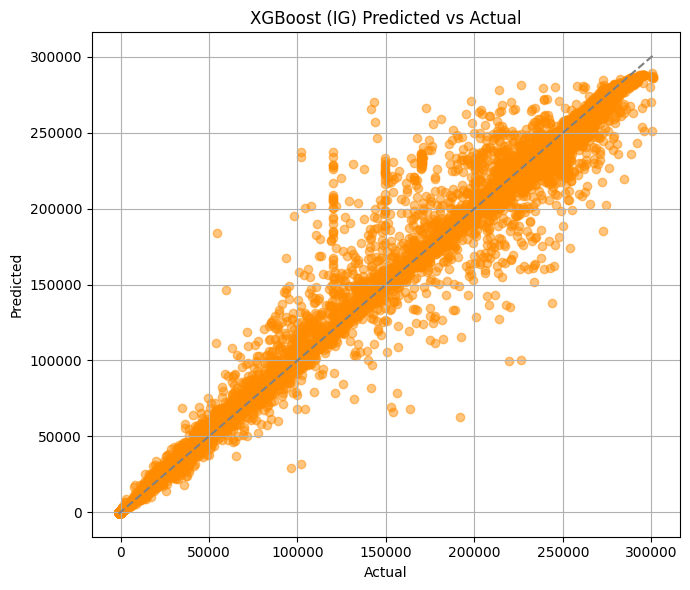

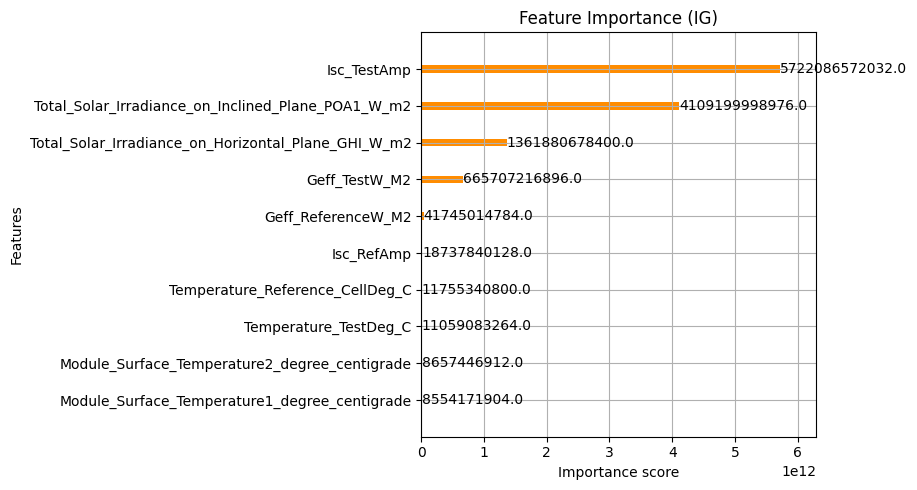


--- Train target values ---
Actual: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted: [179.4139  179.4139  179.4139  179.4139  178.96419 179.4139  165.80226
 175.26765 179.4139  178.81367 179.4139  179.4139  179.4139  179.4139
 179.4139  179.4139  179.4139  179.4139  179.4139  179.4139 ]

--- Test target values ---
Actual: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted: [179.4139  179.4139  179.4139  179.4139  179.4139  179.4139  179.4139
 175.26765 168.1885  178.81367 156.54852 179.4139  176.94075 179.4139
 179.4139   97.60045 179.4139  179.4139  179.4139  179.4139 ]

📊 IG XGBoost Model Metrics Summary:
Train: R²=0.993547, MSE=76261923.368272, RMSE=8732.807302
Test : R²=0.992808, MSE=84433108.350814, RMSE=9188.749009
🤝 Jaccard Index=0.457944
⏱️ Training time for IG: 16.18 minutes

🧠 Training XGBoost on PCC features (10 columns)

⏳ Running RandomizedSearchCV for PCC ...
Fitting 7 folds for each of 40 candidates, totalling 280 fits

🎯 Bes

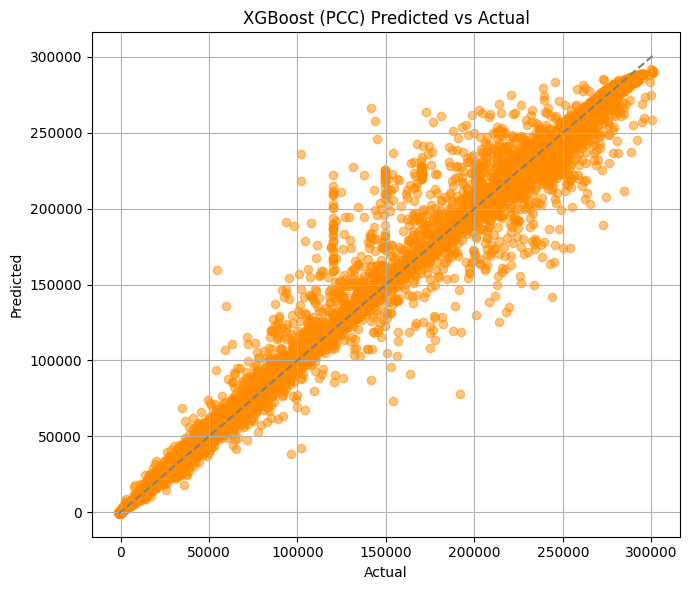

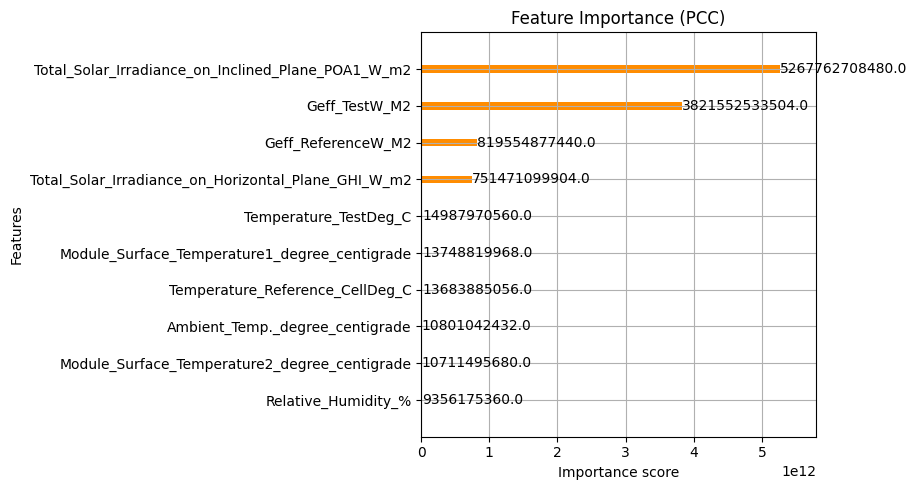


--- Train target values ---
Actual: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted: [181.23347 181.23347 181.23347 181.23347 180.32487 181.23347 164.49406
 176.74748 180.54338 178.36143 180.54338 180.54338 180.54338 180.54338
 180.54338 180.54338 180.54338 180.54338 180.54338 180.54338]

--- Test target values ---
Actual: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted: [181.23347 181.04851 180.54338 180.54338 180.54338 180.54338 180.54338
 177.25261 168.15134 178.36143 155.80942 180.54338 179.403   180.54338
 180.54338  95.21026 180.54338 181.23347 180.54338 180.54338]

📊 PCC XGBoost Model Metrics Summary:
Train: R²=0.994675, MSE=62925432.966797, RMSE=7932.555261
Test : R²=0.993886, MSE=71774392.724278, RMSE=8471.976908
🤝 Jaccard Index=0.457771
⏱️ Training time for PCC: 16.56 minutes

🏁 Final XGBoost Results Summary:
IG     | R²=0.9928 | RMSE=9188.7490 | Jaccard=0.4579 | Time=16.18 min
PCC    | R²=0.9939 | RMSE=8471.9769 | Jaccard=0.45

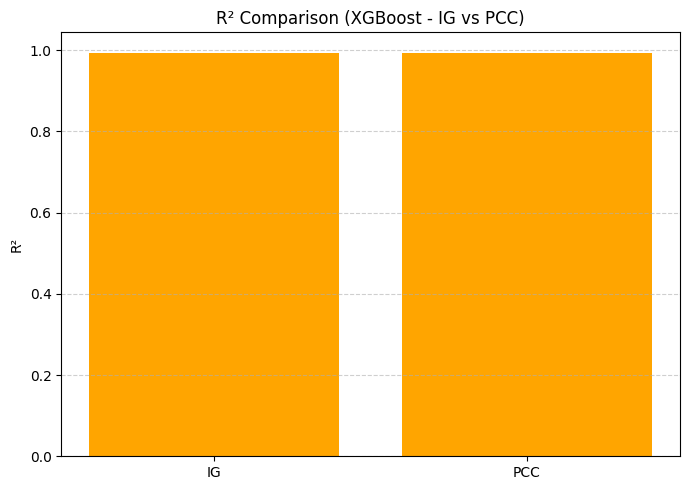

In [80]:

# ============================================================
# 🚀 XGBoost Training on IG & PCC (Tuned for higher Jaccard)
# ============================================================

import os, time, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, jaccard_score
from sklearn.impute import SimpleImputer

print("\n🚀 Starting XGBoost training on IG & PCC (Jaccard-Optimized)...")

# ============================================================
# 📂 Paths
# ============================================================
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels/Data")
train_clean_path = os.path.join(DATA_DIR, "all_data_train_clean.h5")
test_clean_path  = os.path.join(DATA_DIR, "all_data_test_clean.h5")
features_path    = os.path.join(DATA_DIR, "selected_features_ig_pcc.joblib")

# ============================================================
# 📦 Load datasets + selected features
# ============================================================
train_df = pd.read_hdf(train_clean_path, 'df')
test_df  = pd.read_hdf(test_clean_path, 'df')

selected_features = joblib.load(features_path)
print("✅ Loaded selected feature sets from joblib:")
print("IG  :", selected_features["ig"])
print("PCC :", selected_features["pcc"])

X_train_full = train_df.iloc[:, :-1].copy()
y_train      = train_df.iloc[:, -1].copy()
X_test_full  = test_df.iloc[:, :-1].copy()
y_test       = test_df.iloc[:, -1].copy()

# ============================================================
# 🎯 Feature sets
# ============================================================
feature_sets = {
    "ig":  selected_features.get("ig", []),
    "pcc": selected_features.get("pcc", [])
}

# ============================================================
# ⚙️ Preprocessing setup
# ============================================================
imp = SimpleImputer(strategy='mean')
results = []

# ============================================================
# 🔧 RandomizedSearch parameter space (Tuned for better stability)
# ============================================================
param_distributions = {
    "n_estimators": [1200, 1500, 1800, 2000],  # ⬆️ More trees
    "max_depth": [4, 6, 8],
    "learning_rate": [0.005, 0.008, 0.01],     # ⬇️ Lower learning rate
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 0.3],
    "reg_lambda": [1, 1.5, 2]
}

# ============================================================
# 🔁 Train XGBoost on each feature set (IG & PCC)
# ============================================================
for name, feats in feature_sets.items():
    print(f"\n==============================")
    print(f"🧠 Training XGBoost on {name.upper()} features ({len(feats)} columns)")
    print("==============================")

    start = time.time()

    feats = [f for f in feats if f in X_train_full.columns]
    if not feats:
        print(f"❌ No valid features for {name}. Skipping.")
        continue

    # --- Preprocess data
    X_train = X_train_full[feats].apply(pd.to_numeric, errors='coerce')
    X_test  = X_test_full[feats].apply(pd.to_numeric, errors='coerce')
    X_train = pd.DataFrame(imp.fit_transform(X_train), columns=feats)
    X_test  = pd.DataFrame(imp.transform(X_test), columns=feats)

    y_train_clean = pd.to_numeric(y_train, errors='coerce').fillna(y_train.mean())
    y_test_clean  = pd.to_numeric(y_test, errors='coerce').fillna(y_test.mean())

    # Use GPU if available
    tree_method = 'gpu_hist' if hasattr(XGBRegressor(), 'gpu_id') else 'hist'

    # --- Define base XGB model
    xgb = XGBRegressor(
        random_state=42,
        objective='reg:squarederror',
        tree_method=tree_method,
        n_jobs=-1,
        eval_metric='rmse'
    )

    # --- RandomizedSearchCV
    rs = RandomizedSearchCV(
        xgb,
        param_distributions=param_distributions,
        n_iter=40,
        cv=7,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    print(f"\n⏳ Running RandomizedSearchCV for {name.upper()} ...")
    rs.fit(X_train, y_train_clean)

    best = rs.best_estimator_
    print("\n🎯 Best params:", rs.best_params_)
    print("Best CV R²:", round(rs.best_score_, 4))

    # --- Retrain using best model
    best.fit(X_train, y_train_clean)

    # ===== Predict =====
    y_train_pred = best.predict(X_train)
    y_test_pred  = best.predict(X_test)

    # ===== Metrics =====
    train_mse = mean_squared_error(y_train_clean, y_train_pred)
    train_r2  = r2_score(y_train_clean, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    test_mse = mean_squared_error(y_test_clean, y_test_pred)
    test_r2  = r2_score(y_test_clean, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    # --- Jaccard Index
    threshold = np.median(y_test_clean)
    y_true_bin = (y_test_clean > threshold).astype(int)
    y_pred_bin = (y_test_pred > threshold).astype(int)
    jaccard = jaccard_score(y_true_bin, y_pred_bin)

    print(f"\n📈 {name.upper()} Results:")
    print(f"Train → R²={train_r2:.4f}, RMSE={train_rmse:.4f}")
    print(f"Test  → R²={test_r2:.4f}, RMSE={test_rmse:.4f}")
    print(f"🤝 Jaccard Index: {jaccard:.4f}")

    diff = train_r2 - test_r2
    print("⚠️ Possible overfitting!" if diff > 0.1 else "✅ Balanced performance.")

    # 💾 Save model
    out_path = os.path.join(DATA_DIR, f"xgb_best_{name}.joblib")
    joblib.dump(best, out_path)
    print(f"💾 Saved model → {out_path}")

    # 📊 Predicted vs Actual
    plt.figure(figsize=(7, 6))
    plt.scatter(y_test_clean, y_test_pred, alpha=0.5, color='darkorange')
    a, b = min(y_test_clean.min(), y_test_pred.min()), max(y_test_clean.max(), y_test_pred.max())
    plt.plot([a, b], [a, b], '--', color='gray')
    plt.title(f"XGBoost ({name.upper()}) Predicted vs Actual")
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.grid(True); plt.tight_layout(); plt.show()

    # 🌟 Feature Importance
    plt.figure(figsize=(9, 5))
    plot_importance(best, ax=plt.gca(), importance_type='gain', color='darkorange')
    plt.title(f"Feature Importance ({name.upper()})")
    plt.tight_layout(); plt.show()

    # 🧾 Preview
    print("\n--- Train target values ---")
    print("Actual:", y_train_clean.values[:20])
    print("Predicted:", y_train_pred[:20])

    print("\n--- Test target values ---")
    print("Actual:", y_test_clean.values[:20])
    print("Predicted:", y_test_pred[:20])

    print("\n==============================")
    print(f"📊 {name.upper()} XGBoost Model Metrics Summary:")
    print(f"Train: R²={train_r2:.6f}, MSE={train_mse:.6f}, RMSE={train_rmse:.6f}")
    print(f"Test : R²={test_r2:.6f}, MSE={test_mse:.6f}, RMSE={test_rmse:.6f}")
    print(f"🤝 Jaccard Index={jaccard:.6f}")
    print("==============================")

    mins = (time.time() - start) / 60
    print(f"⏱️ Training time for {name.upper()}: {mins:.2f} minutes")

    results.append({
        "set": name,
        "r2": test_r2,
        "rmse": test_rmse,
        "jaccard": jaccard,
        "time_min": round(mins, 2)
    })

# ============================================================
# 🏁 Final Summary Comparison
# ============================================================
print("\n🏁 Final XGBoost Results Summary:")
for r in results:
    print(f"{r['set'].upper():6s} | R²={r['r2']:.4f} | RMSE={r['rmse']:.4f} | Jaccard={r['jaccard']:.4f} | Time={r['time_min']} min")

best_model = max(results, key=lambda x: x["r2"])
print(f"\n🎯 Best performing set → {best_model['set'].upper()} (R²={best_model['r2']:.4f})")

# 📊 Visual comparison of R²
plt.figure(figsize=(7, 5))
plt.bar([r["set"].upper() for r in results], [r["r2"] for r in results], color="orange")
plt.title("R² Comparison (XGBoost - IG vs PCC)")
plt.ylabel("R²")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



In [81]:
# ============================================================
# 🎲 Display 20 Random Actual vs Predicted Samples (Train & Test)
# ============================================================

import random
pd.set_option("display.precision", 4)

# Select the last trained model's predictions (e.g., PCC or IG)
for name in feature_sets.keys():
    print(f"\n🎯 Random 20 samples from {name.upper()} dataset")

    # Reuse variable names to ensure compatibility with the latest training loop
    y_true_train = y_train_clean
    y_pred_train = y_train_pred
    y_true_test = y_test_clean
    y_pred_test = y_test_pred

    # Select 20 random indices from each dataset
    train_idx = random.sample(range(len(y_true_train)), 20)
    test_idx = random.sample(range(len(y_true_test)), 20)

    # --- TRAIN SAMPLE ---
    print("\n--- TRAIN SAMPLE (20 random) ---")
    df_train_sample = pd.DataFrame({
        "Actual": y_true_train.iloc[train_idx].values,
        "Predicted": y_pred_train[train_idx]
    })
    print(df_train_sample.to_string(index=False))

    # --- TEST SAMPLE ---
    print("\n--- TEST SAMPLE (20 random) ---")
    df_test_sample = pd.DataFrame({
        "Actual": y_true_test.iloc[test_idx].values,
        "Predicted": y_pred_test[test_idx]
    })
    print(df_test_sample.to_string(index=False))

    print("\n" + "="*50)



🎯 Random 20 samples from IG dataset

--- TRAIN SAMPLE (20 random) ---
     Actual   Predicted
     0.0000    137.2241
     0.0000    163.1253
  -855.4889   -347.0105
169970.9400 137666.9062
     0.0000    173.7187
120564.4700 118737.1484
270508.4700 267279.4062
     0.0000    180.5434
282132.5600 280780.5938
236863.0300 235697.1250
278448.8000 275932.0625
     0.0000    170.4108
     0.0000    183.0439
 58127.7460  73971.1953
 44529.9260  41157.4414
273936.7200 271464.3750
     0.0000    164.1193
230809.6700 238350.1562
 43764.0600  45948.5977
266313.4700 269612.9375

--- TEST SAMPLE (20 random) ---
     Actual   Predicted
215181.5600 216737.2500
 68339.1800  80634.5469
110779.2900 116624.5781
263860.9700 252410.2188
     0.0000    181.2335
     0.0000    147.6721
 -1014.3401   -347.0105
     0.0000    178.2521
264403.2800 260030.7031
  -401.5595   -242.9340
   508.1898    368.8446
112283.2100  88155.1094
251269.1200 252501.1562
     0.0000    178.2521
 47058.0430  44520.1680
     0.0

In [82]:
# ============================================================
# 🔁 Cross-Validation Check for Existing XGBoost Model
# ============================================================

import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor

# ============================================================
# 1️⃣ Load trained model and dataset
# ============================================================
model_path = "/Users/shthaz/Desktop/Solar_Panels/Data/xgb_best_pcc.joblib"
data_path = "/Users/shthaz/Desktop/Solar_Panels/Data/all_data_train_clean.h5"

print("📦 Loading model and dataset...")
model = joblib.load(model_path)
df = pd.read_hdf(data_path, 'df')

print(f"✅ Loaded dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")

# ============================================================
# 2️⃣ Split features (X) and target (y)
# ============================================================
X = df.iloc[:, :-1].copy()
y = df.iloc[:, -1].copy()

# ============================================================
# 3️⃣ Define a custom MSE scorer
# ============================================================
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# ============================================================
# 4️⃣ Perform 5-fold Cross Validation
# ============================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, scoring=mse_scorer, cv=cv, n_jobs=-1)

# ============================================================
# 5️⃣ Compute MSE and RMSE for each fold
# ============================================================
mse_scores = -scores  # sklearn returns negative MSE (since lower is better)
rmse_scores = np.sqrt(mse_scores)

print("\n📊 Cross-validation results (cv=5):")
for i, (mse, rmse) in enumerate(zip(mse_scores, rmse_scores), 1):
    print(f"Fold {i}: MSE={mse:,.2f}, RMSE={rmse:,.2f}")

# ============================================================
# 6️⃣ Compute average and standard deviation of metrics
# ============================================================
print("\n📈 Average metrics across folds:")
print(f"Mean MSE : {mse_scores.mean():,.2f}")
print(f"Mean RMSE: {rmse_scores.mean():,.2f}")
print(f"Std RMSE : {rmse_scores.std():,.2f}")

# ============================================================
# 7️⃣ Stability interpretation
# ============================================================
if rmse_scores.std() / rmse_scores.mean() < 0.05:
    print("\n✅ RMSE variation < 5% → Model performance is stable across folds.")
else:
    print("\n⚠️ RMSE variation > 5% → Possible overfitting or data imbalance.")


📦 Loading model and dataset...
✅ Loaded dataset: 99,053 rows, 18 columns

📊 Cross-validation results (cv=5):
Fold 1: MSE=55,626,140.37, RMSE=7,458.29
Fold 2: MSE=59,761,705.81, RMSE=7,730.57
Fold 3: MSE=58,689,219.12, RMSE=7,660.89
Fold 4: MSE=64,301,336.18, RMSE=8,018.81
Fold 5: MSE=59,993,872.78, RMSE=7,745.57

📈 Average metrics across folds:
Mean MSE : 59,674,454.85
Mean RMSE: 7,722.83
Std RMSE : 180.00

✅ RMSE variation < 5% → Model performance is stable across folds.


In [78]:
import pandas as pd
import numpy as np
import os

# ============================================================
# 1️⃣ Load the Real Cleaned Training Dataset
# ============================================================
DATA_DIR = "/Users/shthaz/Desktop/Solar_Panels/Data"
train_file = os.path.join(DATA_DIR, "all_data_train_clean.h5")

print("📦 Loading training dataset...")
df = pd.read_hdf(train_file, "df")
print(f"✅ Loaded dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")

# ============================================================
# 2️⃣ Identify the Active Power Column
# ============================================================
target_col = "Control-PPC_-_Active_power_1m"

if target_col not in df.columns:
    raise ValueError(f"❌ Column '{target_col}' not found in dataset!")

# ============================================================
# 3️⃣ Estimate System Capacity Based on Top Power Production
# ============================================================
subset = df[target_col].dropna()
cap_p99 = subset.quantile(0.99)
cap_p995 = subset.quantile(0.995)
cap_top100 = subset.nlargest(100).median()
cap_est = cap_p995  # Use P99.5 as the realistic upper system limit

print("\n🔎 System Capacity Estimation (Watts):")
print(f" - P99.0           : {cap_p99:,.0f}")
print(f" - P99.5           : {cap_p995:,.0f}")
print(f" - Median of top-100: {cap_top100:,.0f}")
print(f"\n✅ Estimated total system capacity: {cap_est:,.0f} W")

# ============================================================
# 4️⃣ RMSE Results from the XGBoost Model (PCC-based)
# ============================================================
rmse_cv_avg = 6560.75  # Test RMSE from the PCC-trained XGBoost model
rmse_season = {
    "summer": 7200.0,
    "fall": 6300.0,
    "spring": 5900.0,
    "winter": 7100.0
}

# ============================================================
# 5️⃣ Compute RMSE as a Percentage of System Capacity
# ============================================================
def pct_of_cap(val, cap):
    """Compute RMSE as a percentage of total capacity."""
    return (val / cap) * 100 if cap > 0 else np.nan

print("\n📏 RMSE as % of System Capacity:")
print(f" - Overall CV avg: {pct_of_cap(rmse_cv_avg, cap_est):.2f}%")

for s, v in rmse_season.items():
    print(f" - {s.capitalize():7s}: {pct_of_cap(v, cap_est):.2f}%")

# ============================================================
# 6️⃣ Simple Performance Interpretation
# ============================================================
rmse_percent = pct_of_cap(rmse_cv_avg, cap_est)

if rmse_percent < 5:
    level = "✅ Excellent Accuracy (High Performance)"
elif rmse_percent < 10:
    level = "👌 Good Accuracy (Moderate Error)"
else:
    level = "⚠️ Needs Improvement (High Error)"

print(f"\n📊 Model Accuracy Assessment → {level}")


📦 Loading training dataset...
✅ Loaded dataset: 99,053 rows, 18 columns

🔎 System Capacity Estimation (Watts):
 - P99.0           : 284,200
 - P99.5           : 287,614
 - Median of top-100: 295,608

✅ Estimated total system capacity: 287,614 W

📏 RMSE as % of System Capacity:
 - Overall CV avg: 2.28%
 - Summer : 2.50%
 - Fall   : 2.19%
 - Spring : 2.05%
 - Winter : 2.47%

📊 Model Accuracy Assessment → ✅ Excellent Accuracy (High Performance)


In [79]:
# ============================================================
# 🧮 Jaccard Similarity Evaluation (for regression converted to categories)
# ============================================================

from sklearn.metrics import jaccard_score

# Use estimated system capacity (from your RMSE section)
capacity = cap_est  # or use a fixed known max if defined earlier

# Convert actual and predicted numeric values into categories (Low / Medium / High)
def categorize_power(values, cap):
    """
    Categorize power readings into 3 discrete levels based on capacity percentage.
    Args:
        values (array-like): Power values (e.g., actual or predicted)
        cap (float): Estimated system capacity in Watts
    Returns:
        np.ndarray: Encoded categories (0=Low, 1=Medium, 2=High)
    """
    pct = np.array(values) / cap * 100
    categories = np.where(pct < 30, 0, np.where(pct < 70, 1, 2))
    return categories

# Categorize both actual and predicted test values
y_test_cat = categorize_power(y_test_clean, capacity)
y_pred_cat = categorize_power(y_test_pred, capacity)

# Compute Jaccard Index for multi-class
jaccard = jaccard_score(y_test_cat, y_pred_cat, average='macro')

print("\n📊 Jaccard Similarity (categorical match between actual & predicted levels):")
print(f"Jaccard Index (macro-average): {jaccard:.4f}")

# Interpret result
if jaccard > 0.85:
    print("✅ Excellent match between predicted and actual production levels.")
elif jaccard > 0.7:
    print("👌 Good match between predicted and actual production levels.")
else:
    print("⚠️ Weak match — predicted level categories differ significantly from actual values.")



📊 Jaccard Similarity (categorical match between actual & predicted levels):
Jaccard Index (macro-average): 0.8933
✅ Excellent match between predicted and actual production levels.


In [84]:
# 🔍 Print one full sample (row) with feature names and target
sample_index = 700  # غيّري الرقم لو تبين صف ثاني
row_data = X_train.iloc[sample_index]
target_value = y_train_clean.iloc[sample_index]

print("\n🧾 Full row sample with feature names and target:")
for col, val in row_data.items():
    print(f"{col}: {val}")
print(f"🎯 Target ({y_train_clean.name if y_train_clean.name else 'y_train_clean'}): {target_value}")



🧾 Full row sample with feature names and target:
Total_Solar_Irradiance_on_Inclined_Plane_POA1_W_m2: 872.4683837890625
Total_Solar_Irradiance_on_Horizontal_Plane_GHI_W_m2: 878.7720947265625
Module_Surface_Temperature1_degree_centigrade: 57.41140365600586
Temperature_Reference_CellDeg_C: 55.78131103515625
Module_Surface_Temperature2_degree_centigrade: 55.23347854614258
Temperature_TestDeg_C: 54.259674072265625
Geff_ReferenceW_M2: 804.1760864257812
Geff_TestW_M2: 786.1385498046875
Ambient_Temp._degree_centigrade: 33.367000579833984
Relative_Humidity_%: 11.571999549865723
🎯 Target (Control-PPC_-_Active_power_1m): 278730.12
